## Importing necessary libraries

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## Reading the dataset

In [4]:
data = pd.read_csv(r"C:\Users\aryag\Downloads\uber.csv")
data.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


## Exploratory Data Analysis

In [6]:
print(data.info())
print(data.describe())
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB
None
         Unnamed: 0    fare_amount  pickup_longitude  pickup_latitude  \
count  2.000000e+05  200000.000000     200000.000000    200000.000000   
mean   2.771250e+07      11.359955        -72.527638        39.935885   
std    1.601382e+07       9.901776         11.437787         7.7

## Handle Missing Data

In [8]:
# Removing invalid latitude and longitude values
data = data[
    (data['pickup_latitude'].between(-90, 90)) & 
    (data['pickup_longitude'].between(-180, 180)) &
    (data['dropoff_latitude'].between(-90, 90)) & 
    (data['dropoff_longitude'].between(-180, 180))
].copy()

In [9]:
# Dropping rows with missing fare amount
data.dropna(subset=['fare_amount'], inplace=True)

## Feature Engineering

In [11]:
# Function to calculate distance
from geopy.distance import geodesic
def haversine_distance(row):
    pickup = (row['pickup_latitude'], row['pickup_longitude'])
    dropoff = (row['dropoff_latitude'], row['dropoff_longitude'])
    if pd.isnull(row['pickup_latitude']) or pd.isnull(row['pickup_longitude']) or pd.isnull(row['dropoff_latitude']) or pd.isnull(row['dropoff_longitude']):
        return None  # Return None for missing values
    return geodesic(pickup, dropoff).km  # Calculate distance in km

data['distance_km'] = data.apply(haversine_distance, axis=1)
# Dropping rows where distance is NaN
data.dropna(subset=['distance_km'], inplace=True)

## Creating time of day feature
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['hour'] = data['pickup_datetime'].dt.hour
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

data['time_of_day'] = data['hour'].apply(get_time_of_day)

## Train-Test Split

In [13]:
from sklearn.model_selection import train_test_split
X = data[['distance_km', 'hour']]
y = data['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Data Scaling

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Correlation Analysis

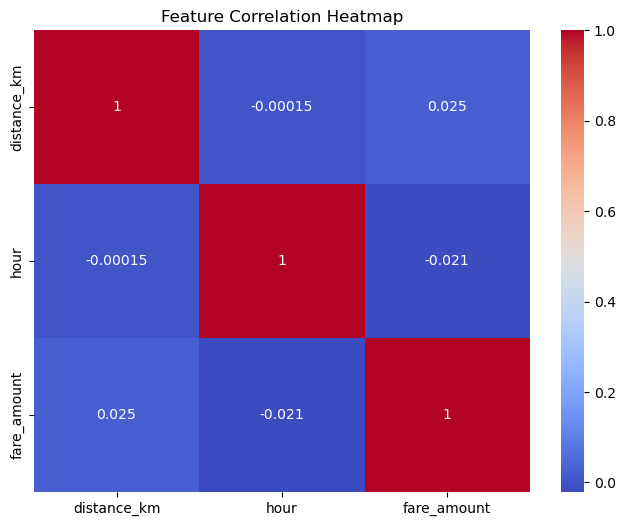

In [17]:
plt.figure(figsize=(8,6))
sns.heatmap(data[['distance_km', 'hour', 'fare_amount']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

## Train the Decision Tree Regression Model

In [19]:
from sklearn.tree import DecisionTreeRegressor

In [20]:
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train_scaled, y_train)
y_pred = dt_model.predict(X_test_scaled)


In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score# 8. Model Evaluation

In [22]:
print("\nDecision Tree Model Performance:")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"R2 Score: {r2_score(y_test, y_pred)}")


Decision Tree Model Performance:
MAE: 3.3429928352669678
MSE: 51.03741261431965
R2 Score: 0.46078535108347474


In [23]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
decision_tree = DecisionTreeRegressor()
grid_search = GridSearchCV(decision_tree, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [5, 10, 15, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='r2')

In [24]:
# Best parameters from GridSearch
best_tree = grid_search.best_estimator_
y_pred = best_tree.predict(X_test_scaled)


## Model Evaluation

In [26]:
print("\nDecision Tree Model Performance:")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"R2 Score: {r2_score(y_test, y_pred)}")


Decision Tree Model Performance:
Best Parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}
MAE: 2.5140307423371073
MSE: 26.455469133142984
R2 Score: 0.7204956958075249


In [27]:
 # Sample Predictions

In [28]:
print("\nSample Predictions:")
print(pd.DataFrame({
    'Actual Fare': y_test.values[:5],
    'Predicted Fare': y_pred[:5]
}))


Sample Predictions:
   Actual Fare  Predicted Fare
0          5.5        5.478424
1         10.5       13.388212
2          4.1        5.478424
3         21.3       19.266653
4          6.9        9.820221


In [35]:
# Display sample results

In [52]:
print(data[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'distance_km', 'fare_amount']].head())

   pickup_latitude  pickup_longitude  dropoff_latitude  dropoff_longitude  \
0        40.738354        -73.999817         40.723217         -73.999512   
1        40.728225        -73.994355         40.750325         -73.994710   
2        40.740770        -74.005043         40.772647         -73.962565   
3        40.790844        -73.976124         40.803349         -73.965316   
4        40.744085        -73.925023         40.761247         -73.973082   

   distance_km  fare_amount  
0     1.681111          7.5  
1     2.454363          7.7  
2     5.039603         12.9  
3     1.661442          5.3  
4     4.483730         16.0  


In [54]:
# 8. Feature Importance

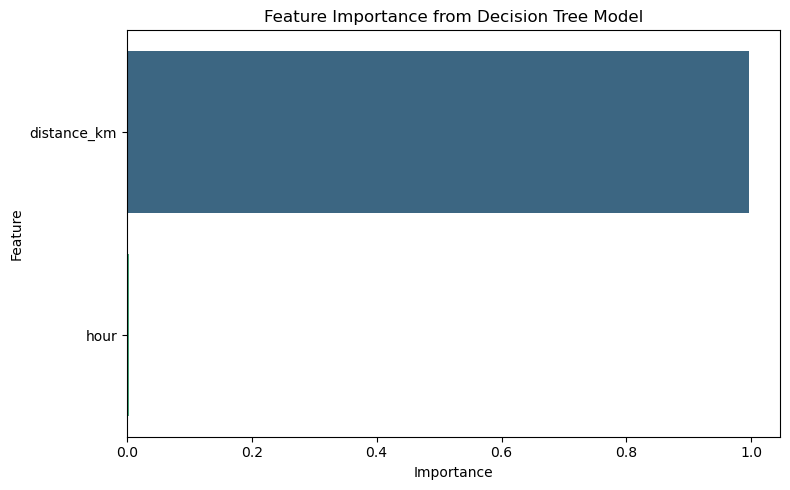


Feature Importance:
       Feature  Importance
0  distance_km     0.99609
1         hour     0.00391


In [56]:
importances = best_tree.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Plotting Feature Importance
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance from Decision Tree Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\nFeature Importance:")
print(feature_importance_df)

In [58]:
# 9. Make Predictions on New Data
# Example: New ride data with distance and hour
new_data = pd.DataFrame({
    'distance_km': [3.5, 10.2, 0.8],  # Example distances in km
    'hour': [9, 18, 23]               # Example pickup hours
})

# Apply the same scaling used during training
new_data_scaled = scaler.transform(new_data)

# Predict using the trained model
new_predictions = best_tree.predict(new_data_scaled)

# Display predictions
print("\nPredicted Fare Amounts for New Data:")
for i, fare in enumerate(new_predictions):
    print(f"Ride {i+1}: Estimated Fare = ${fare:.2f}")



Predicted Fare Amounts for New Data:
Ride 1: Estimated Fare = $11.39
Ride 2: Estimated Fare = $30.78
Ride 3: Estimated Fare = $5.48


## Use Cases and Benefits of Predictions

*By using your trained Decision Tree regression model, you can:*
- Estimate fares for customers in real-time, improving transparency and trust.
- Help drivers and platforms manage pricing dynamically based on ride patterns.
- Detect anomalies by flagging predicted fares that deviate drastically from actual ones.
- Integrate predictions into a mobile app or web-based system for better ride planning and fare calculation.

## Recommendations Based on Regression Model Insights

1. **Dynamic Pricing Based on Distance and Time**  
   Distance has the highest feature importance in our model, indicating that pricing strategies should be primarily distance-driven. This supports the use of real-time distance data in dynamic fare calculations.

2. **Promotions During Off-Peak Hours**  
   Our model includes 'hour' as a feature, and we noticed variations in fare amounts based on time. Implementing incentives for customers during off-peak times can improve demand distribution.

3. **Driver Incentives for Peak Hours**  
   Higher predicted fares during evening hours suggest increased demand. Offering bonuses or surge pricing during such hours can help balance driver availability.

4. **Fare Estimation Feature**  
   The trained model can be used in-app to provide accurate fare estimates, building user trust and aiding ride decision-making.

5. **Anomaly Detection for Monitoring**  
   Use the model to flag rides where actual fares significantly deviate from predictions. This can help detect anomalies or potential fare manipulation.
